<a href="https://colab.research.google.com/github/pfaendler/ETH_SysBio_Exercises/blob/main/SysBio_ROC_PR_Curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) ROC and PR curves - Introduction
Developments in machine learning have enabled biologists to build models for various classification tasks (e.g. WT mouse vs. KO mouse). In this exercise we are going to learn how to assess the perfomance of a model (how good or how bad it is) using different metrics including "Receiver Operating Characteristic" (ROC) or "Precision Recall" (PR) curves. 

To do so, we first need to define some terms, which will help us to understand these details behind these metrics.

Commonly, we would like to predict to which class a sample belongs to with our model. This will result in 4 different possibilities:

 - **True Positives (TP)** - both actual value and prediction are 'true' (e.g. WT mouse predicted to be WT)
 - **False Positives (FP)** - actual value is 'false' and prediction is 'true' (e.g. KO mouse predicted to be WT)
 - **False Negatives (FN)** - actual value is 'true' and prediction is 'false' (e.g. WT mouse predicted to be KO)
 - **True Negatives (TN)** - both actual value and prediction are 'false' (e.g. KO mouse predicted to be KO)

These resulting values can be visualised in a so-called 'confusion matrix':


<img src='https://cdn.analyticsvidhya.com/wp-content/uploads/2020/04/Basic-Confusion-matrix.png' width=300px><br> 
<em>**Figure 1:** Schematic confusion matrix <br> (copied from https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/) </em>

And from here, different metrics can be calculated:

 - **Specificity** = $TN \over TN + FP $
 - **Precision** = $TP \over TP + FP $
 - **False Positive Rate** = $FP \over TN + FP $ = 1 - Specificity 
 - **True Positive Rate = Sensitivity = Recall** = $TP \over TP + FN $

These metrics are the baseline for ROC and PR curves, which help us to display the performance of a model in a graphical way.


# 2) Example - Covid-19 Saliva Test
Let's look at these different metrics in an easier example. Suppose you have developed a COVID-19 test that can be used to detect the presence of the virus in a patient's saliva sample. Your test gives a numerical score ranging from 0 to 100, with higher scores indicating an increased chance of being COVID-19 positive. You want to evaluate the performance of your test using different metrics. 

For the purpose of this example, we will create the data ourselves. 



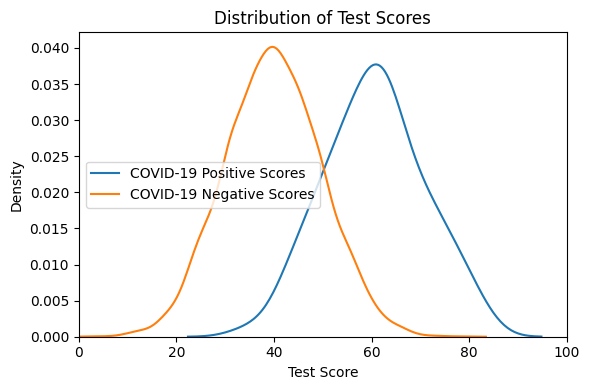

In [ ]:
# we first need to import some python modules 
import numpy as np #for matrix manipulations 
import matplotlib.pyplot as plt # for plotting
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve # to display different metrics & curves
import seaborn as sns # for density plots

# Simulate a COVID-19 test dataset with 5000 patients, of which 100 are covid positive.
np.random.seed(0) #for reproducibility
n_patients = 5000
n_covid_pos = 100
n_covid_neg = n_patients - n_covid_pos

# We create our saliva test results by drawing from two different normal distributions using different means for each group. 
# This means, on average, the scores of covid pos. are higher, but the two distributions overlap.
covid_pos_scores = np.random.normal(loc=60, scale=10, size=n_covid_pos)
covid_neg_scores = np.random.normal(loc=40, scale=10, size=n_covid_neg)

# Combine the saliva test results in 'test_scores' and save the true label (in both np.arrays the first 100 are the positive ones)
test_scores = np.concatenate((covid_pos_scores, covid_neg_scores))
true_labels = np.concatenate((np.ones(n_covid_pos), np.zeros(n_covid_neg)))



Let's show the overlap of the two distributions:

**Question**: What do you think would be a good threshold here? And can you visualise it on the plot?


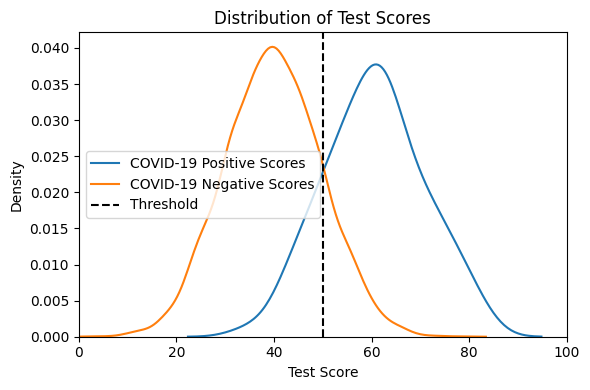

85 747 4153 15


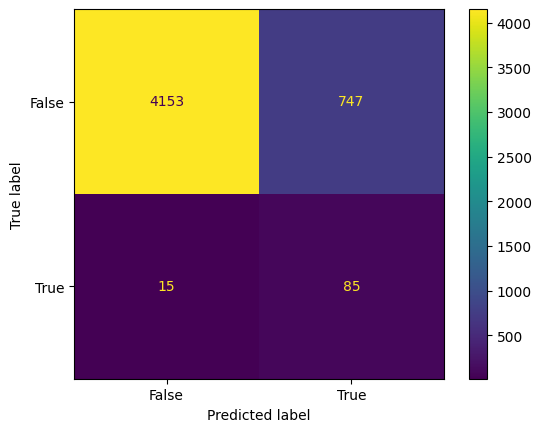

0.10216346153846154
0.85
0.15244897959183673


In [ ]:
# Now, assume that our test sets the thresholds at 50 (which is more or less dividing the two distributions). Using this threshold, we can now take a look at the different metrics. 
plt.figure(figsize=(6, 4))
sns.kdeplot(covid_pos_scores,  label='COVID-19 Positive Scores')
sns.kdeplot(covid_neg_scores,  label='COVID-19 Negative Scores')
plt.axvline(x=50, color='black', linestyle='--', label='Threshold') # Question: Can you visualise the threshold? (use plt.axvline)
plt.xlabel('Test Score')
plt.xlim([0, 100])
plt.ylabel('Density')
plt.title('Distribution of Test Scores')
plt.legend()

plt.tight_layout()
plt.show()


Now use this thresehold and calculate the different metrics!

In [ ]:

# Similar to the 'true_labels' create the 'test_labels' based on a threshold of 50 QUESTION?
test_labels = test_scores>50

# Calculate the four different values introduced in 1.1
tp = np.sum((true_labels ==1) & (test_labels ==True))
fp = np.sum((true_labels ==0) & (test_labels ==True)) #QUESTION
tn = np.sum((true_labels ==0) & (test_labels ==False)) #QUESTION
fn = np.sum((true_labels ==1) & (test_labels ==False)) #QUESTION

print(tp, fp, tn, fn)

# Can you also visualise this in a confusion matrix?
confusion_matrix = metrics.confusion_matrix(true_labels, test_labels)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()


# Calculate the different metrics introduced in chapter 1.1 based on a threshold of 50
precision = tp/(tp+fp)
print(precision)
specificity = tn/(tn+fp)
print(specificity)
recall = tp/(tp+fn)
print(recall)
false_pos_rate = fp/(tn+fp)
print(false_pos_rate)

## Questions
**Question:** What do these values mean for our saliva test with a threshold of 50? (Answer this question from a precision and recall perspective)


1) Our Covid-19 test has a precision of 0.102 at threshold 50, meaning that 
when it predicts a patient is Covid-19 positive, it is correct in 10.2% of the cases. \\
2)  The saliva test, at threshold 50 has a recall of 0.85, meaning it correctly identifies 85% of all Covid-19 positive cases.



**Question:** At this threshold our test does not work very well, it gives quite a high number of false positives. But what would we want from our test?



This is not a simple question to answer. On the one hand we would want to stop the virus from spreading to contain it better in the first place. To do so, we would want to minimise false negatives but take more false positives into account. \\
On the other hand one would also want to avoid that non-infected individuals don't have to isolate unnecessarily, as this could affect e.g. the economy. This actually seems to be a problem here, only 10% of the test-positive inidviduals actually carry the disease, but the other 90% are actually not infected. 

# 3) ROC curve

Instead of setting the threshold manually, we can also look how this binary classification for our test works across thresholds. To do this, we can use a ROC curve.
A ROC curve is a graphical representation of the performance of a binary classifier across different thresholds and is based on the false positive rate (FPR) on the x-axis and the true positive rate (TPR) on the y-axis.

<img src='https://upload.wikimedia.org/wikipedia/commons/1/13/Roc_curve.svg' width=500px><br> 
<em>**Figure 2:** Schematic ROC curve <br> (copied from https://commons.wikimedia.org/wiki/File:Roc_curve.svg) </em>2


As you can see, a perfect classifier would have a ROC curve that passes through the top left corner of the graph, whereas a random classifier would have a ROC curve that goes diagonally from the bottom left to the top right.
In reality, these curves are often somewhere in between the two extremes.


ROC curves can also be described in a quantiative way, which is commonly referred to as the respective ROC curve's 'Area Under Curve' (AUC, also known as AUROC, area under receiver operating characteristic) value. While a perfect classifier would have an AUC of 1, a random classifier would have a value of 0.5. 



Let us revisit our previous example from a ROC curve perspective:





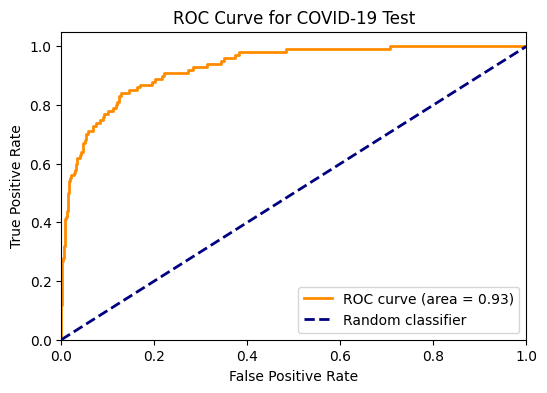

In [ ]:
# using the function 'roc_curve' from sklearn.metrics we can retrieve the fpr, tpr, etc. from our example
fpr, tpr, thresholds = roc_curve(true_labels, test_scores)
# we can also calculate the auc
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label = 'Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for COVID-19 Test')
plt.legend(loc="lower right")
plt.show()

**Question:** Would you consider our saliva test to perform well in this binary classification?




According to the ROC curve our binary classifier seems to work quite accurately, as the AUC is quite high!

**Question:** Can you display, where on the curve our previously used threshold lies?

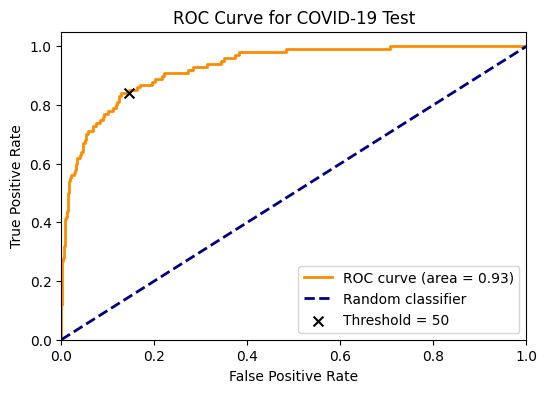

In [ ]:
# Where can we find our previous threshold of 50 in this plot?
idx = np.argmin(np.abs(fpr - false_pos_rate))

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label = 'Random classifier')
plt.scatter(fpr[idx], tpr[idx],zorder = 2, marker= 'x', color='black', s=50, label=f'Threshold = 50')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for COVID-19 Test')
plt.legend(loc="lower right")

plt.show()

## Questions

1) Where would you draw a threshold for our test?\
2) According to the ROC curve's AUC the saliva test performs quite well, what do you think about it if you look at the confusion matrix? Can you explain why the AUC is that high?


## Answers
1) This really depends on what the goal is, but considering that maybe people would first do this saliva-based test and then, if positive, a proper test (e.g. PCR test) which is more accurate, we can maybe take some false positves into account.

2) The problem could be that our dataset is quite unbalanced. There is only a fraction of individuals that are actually positive, but quite a lot of non-infected ones. In the ROC world, which is dependant on FPR and TPR, this can lead to quite skewed results. For the e.g. the TPR contains the false negatives (infected indivuals, but test says they are not), but these are relatively unlikely as the number of infected individuals in general is low in the first place (only 100 of 5000). The inbalance of the dataset also affects the FPR, which is dependant on the true negatives (non-infected individual, and test is negative). With the big majority of individuals not infected in general, this is highly skewing the FPR towards a small value, which looks well relatively quickly then. 

# 4) PR curves

Another graphical representation to check the performance of a binary classifier is the PR (precision-recall) curve. In a PR curve, the x-axis represents the recall or sensitivity, which is the proportion of true positives (instances correctly classified as positive) out of all the actual positives in the dataset. The y-axis represents the precision or positive predictive value (PPV), which is the proportion of true positives out of all the instances classified as positive by the classifier. The PR curve summarises the trade-off between precision and recall for different classification thresholds.

Let's revisit our Covid-19 saliva test with PR curves. 

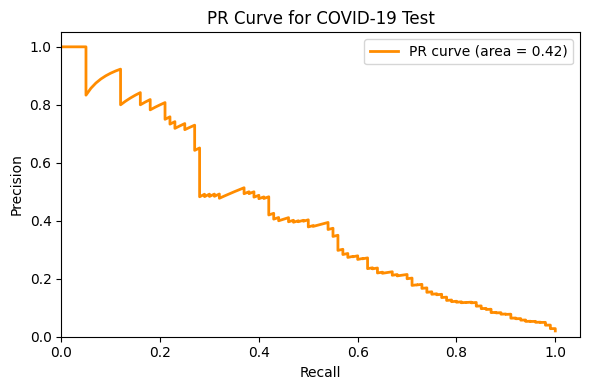

In [ ]:
# Calculate the precision and recall for different discrimination thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, test_scores)
pr_auc = auc(recall, precision)

# Plot the PR curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve for COVID-19 Test')
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

## Questions
1) Why is the score of the PR curve so low? \
2) When do you think is a PR curve more appropriate?

## Answers
1) While a PR curve also contains the TPR (= recall), it is also based on the precision, which is based on true, but also false positives. In our imbalanced dataset with a lot of false positives (747 of 5000 at threshold 50), the precision goes down very quickly, even across different thresholds.

2) As we have just seen in our example, in cases where the classes are imbalanced (and with high false positive rates) a PR curve assesses the performance of binary classifiers better.  

# 5) How does this look like for different tests?

In the last part of this exercise, we want you to analyse a similarly synthetic dataset. This one is based on 500 patients that were selected for a comparison of different tests. Therefore, the study selected 250 cases that were positive and 250 cases that were not infected. Plot the ROC and PR curves for each of the test in one plot (hint: use a for loop).

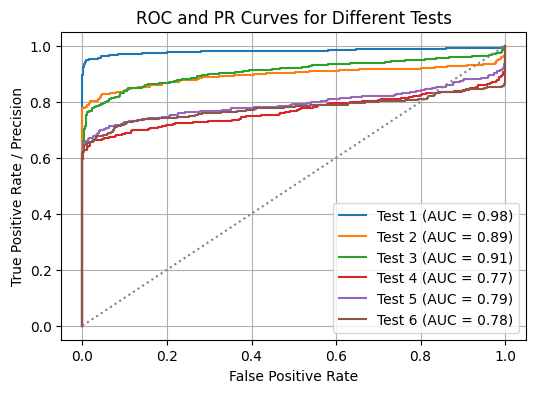

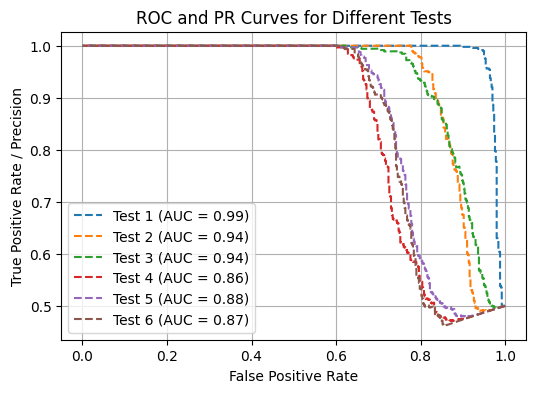

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Generate sample data
np.random.seed(42)
n_samples = 500

# Test 1 
test1_pos_scores = np.random.normal(loc=18, scale=1, size=n_samples)
test1_neg_scores = np.random.normal(loc=28, scale=5, size=n_samples)
test1_scores = np.concatenate([test1_pos_scores,test1_neg_scores])
test1_labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

# Test 2 
test2_pos_scores = np.random.normal(loc=22, scale=1, size=n_samples)
test2_neg_scores = np.random.normal(loc=28, scale=5, size=n_samples)
test2_scores = np.concatenate([test2_pos_scores,test2_neg_scores])
test2_labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

# Test 3 
test3_pos_scores = np.random.normal(loc=24, scale=1, size=n_samples)
test3_neg_scores = np.random.normal(loc=28, scale=3, size=n_samples)
test3_scores = np.concatenate([test3_pos_scores,test3_neg_scores])
test3_labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

# Test 4 
test4_pos_scores = np.random.normal(loc=24, scale=1, size=n_samples)
test4_neg_scores = np.random.normal(loc=28, scale=5, size=n_samples)
test4_scores = np.concatenate([test4_pos_scores,test4_neg_scores])
test4_labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

# Test 5 
test5_pos_scores = np.random.normal(loc=22, scale=1, size=n_samples)
test5_neg_scores = np.random.normal(loc=26, scale=5, size=n_samples)
test5_scores = np.concatenate([test5_pos_scores,test5_neg_scores])
test5_labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])

# Test 6 
test6_pos_scores = np.random.normal(loc=20, scale=1, size=n_samples)
test6_neg_scores = np.random.normal(loc=25, scale=6, size=n_samples)
test6_scores = np.concatenate([test6_pos_scores,test6_neg_scores])
test6_labels = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])


# Compute ROC curve and AUC for each test
tests_scores = [test1_scores, test2_scores, test3_scores, test4_scores, test5_scores, test6_scores]
tests_labels = [test1_labels, test2_labels, test3_labels, test4_labels, test5_labels, test6_labels]
labels = ['Test 1', 'Test 2', 'Test 3', 'Test 4', 'Test 5', 'Test 6']

plt.figure(figsize=(6, 4))

for i in range(len(tests_scores)):
    fpr, tpr, _ = roc_curve(tests_labels[i], tests_scores[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle=':', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC and PR Curves for Different Tests')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(6, 4))

for i in range(len(tests_scores)):
    precision, recall, _ = precision_recall_curve(tests_labels[i], tests_scores[i])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, linestyle='--', label=f'{labels[i]} (AUC = {pr_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate / Precision')
plt.title('ROC and PR Curves for Different Tests')
plt.legend()
plt.grid(True)
plt.show()

## Questions:
1) What is different in terms of the first part of this exercise, and how does this translate to the ROC and PR curves?

2) Given the performance of these different tests for detection of Covid-19, how would you make a decision on which test to choose? Consider Test 1, which has the best performance but is the most expensive, and Tests 2 and 3, which perform well but are less expensive. What factors would you consider, and what trade-offs would you make?


## Answers:
1) With the balanced datasets, both ROC and PR curve reflect the properties of the tests quite similarly.\
2) Given that Test 1 performs best but is super expensive it would probably be a test that could be useful in a delicate setting (e.g. hospital), where people at risk need to be protected well enough, however it would not be suitable for mass testing. 
Test2 and Test3 could be used in a mass-test setting,  as they are less expensive and perform reasonably well. This would allow people to test themselves and, if they are positive, they could then still be referred to a testing site which offers a more accurate test such as Test 1. 
From a manufacturers point of view, we have not looked at specific thresholds that could be useful for the tests, and this would give further discussion points. 